# Desafio Kaggle - Titanic

Iniciando minha jornada no Kaggle, decidi começar pelo famoso Desafio do Titanic. O objetivo é desenvolver um modelo preditivo que, com base nas características dos passageiros, prevê se eles sobreviveram ou não. Neste desafio, pude aplicar alguns conhecimentos como análise exploratória de dados, uso de pipelines para pré-processamento e a modelagem propriamente dita. Utilize dois modelos diferentes e comparei os resultados para avaliar o desempenho.
___________________________________

## 1. Libs, Funções e Configs

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings
import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

### 1.1 Funções

In [2]:
def metadados(df):
    
    summary_data = []

    for column in df.columns:
        feature_name = column

        qt_nulls = df[column].isnull().sum()
        pct_nulls = f'{(qt_nulls / len(df)) * 100:.2f}%'
        qt_zeros = (df[column] == 0).sum()
        pct_zeros = f'{(qt_zeros / len(df)) * 100:.2f}%'
        cardinality = df[column].nunique()
        tipo_feature = str(df[column].dtype)

        summary_data.append([feature_name, qt_nulls, pct_nulls, qt_zeros, pct_zeros, cardinality, tipo_feature])

    summary_df = pd.DataFrame(summary_data, columns=['FEATURE', 'QT_NULOS', 'PC_NULOS', 'QT_ZEROS', 'PCT_ZEROS', 'CARDINALIDADE', 'TIPO_FEATURE'])
    
    return summary_df

In [3]:
def analyze_variable(dataframe, variable, target): 

    # se a variável for numérica, arredonda para 4 casas decimais
    if pd.api.types.is_numeric_dtype(dataframe[variable].dtypes) == True and pd.api.types.is_bool_dtype(dataframe[variable].dtypes) == False:
        dataframe[variable] = dataframe[variable].round(4)
        dataframe[variable] = dataframe[variable].astype(str)

    # calcula a taxa de evento e o volume para cada categoria da variável
    result = dataframe.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
    result.columns = [variable, 'Taxa_de_Evento', 'Volume']

    # ordena o resultado pela Taxa de Evento em ordem decrescente
    result = result.sort_values(by='Taxa_de_Evento', ascending=False)

    result['Taxa_de_Evento'] = result['Taxa_de_Evento'] * 100

    # plota o gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # eixo Y esquerdo: Volume
    bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Volume', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # eixo Y direito: Taxa de Evento
    ax2 = ax1.twinx()
    lines = ax2.plot(result[variable], result['Taxa_de_Evento'], marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
    ax2.set_ylabel('Taxa de Evento (%)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'
    plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
    labels = [plot.get_label() for plot in plots]
    plt.legend(plots, labels, loc='upper left')

    plt.title(f'Volume e Taxa de Evento por {variable}')
    plt.xticks(rotation=45)  # adicionado para melhor visualização dos labels no eixo X
    plt.tight_layout()
    plt.show()

    return result

In [4]:
def categorize_with_decision_tree(dataframe, n_categories, target, numeric_var):
    # preparar os dados
    X = dataframe[[numeric_var]]
    y = dataframe[target]

    # treinar uma árvore de decisão com profundidade máxima igual ao número de categorias desejadas
    tree = DecisionTreeClassifier(max_leaf_nodes = n_categories)
    tree.fit(X, y)

    # predizer a categoria (folha) para cada entrada no DataFrame
    leaf_ids = tree.apply(X)

    # criar um DataFrame temporário com as categorias (folhas), a variável numérica e o target
    temp_df = pd.DataFrame({numeric_var: dataframe[numeric_var], 'Leaf': leaf_ids, target: y})

    result = temp_df.groupby('Leaf').agg({target: 'mean', numeric_var: ['count', 'min', 'max']}).reset_index()
    result.columns = ['Leaf', 'Taxa_de_Evento', 'Volume', 'Lower_Bound', 'Upper_Bound']

    result['Taxa_de_Evento'] = result['Taxa_de_Evento'] * 100 

    # ajuste para garantir que os limites superior e inferior de bins adjacentes não se sobreponham
    result = result.sort_values(by='Lower_Bound').reset_index(drop=True)
    for i in range(1, len(result)):
        result.at[i, 'Lower_Bound'] = max(result.at[i, 'Lower_Bound'], result.at[i-1, 'Upper_Bound'])

    # definir o limite inferior do primeiro bin como -inf e o limite superior do último bin como inf
    result.at[0, 'Lower_Bound'] = -np.inf
    result.at[len(result) - 1, 'Upper_Bound'] = np.inf
    
    return result

In [5]:
def get_transformed_feature_names(preprocessor, cat_cols, num_cols):
    
    cat_feature_names = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_cols)
    
    num_feature_names = np.array(num_cols)
    
    feature_names = np.concatenate([cat_feature_names, num_feature_names])

    return feature_names

## 2. Obtenção dos Dados e EDA

In [6]:
# lendo o arquivo csv contendo os dados de treino
df_train = pd.read_csv('\\Titanic\\train.csv', sep = ',')

# lendo o arquivo csv contendo os dados de test
df_test_x = pd.read_csv('\\Titanic\\test.csv', sep = ',') 

In [7]:
# visualizando as cinco primeiras
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [8]:
# visualizando a volumetria e tipo de dados
df_train.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# describe dos dados de treino
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [10]:
# metadados dos dados de treino
metadados(df_train)

,FEATURE,QT_NULOS,PC_NULOS,QT_ZEROS,PCT_ZEROS,CARDINALIDADE,TIPO_FEATURE
0,PassengerId,0,0.00%,0,0.00%,891,int64
1,Survived,0,0.00%,549,61.62%,2,int64
2,Pclass,0,0.00%,0,0.00%,3,int64
3,Name,0,0.00%,0,0.00%,891,object
4,Sex,0,0.00%,0,0.00%,2,object
5,Age,177,19.87%,0,0.00%,88,float64
6,SibSp,0,0.00%,608,68.24%,7,int64
7,Parch,0,0.00%,678,76.09%,7,int64
8,Ticket,0,0.00%,0,0.00%,681,object
9,Fare,0,0.00%,15,1.68%,248,float64


<Axes: >

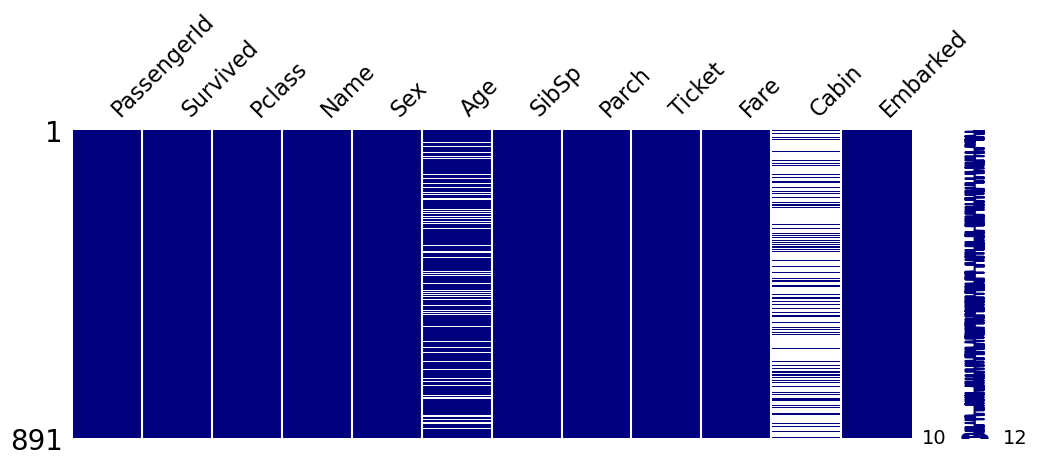

In [11]:
# visualização gráfica do preenchimento dos campos
msno.matrix(df_train, color = (0.0, 0.0, 0.5), figsize = (12, 4))

### Insights até o momento

* A base de dados contém 12 características; no entanto, 4 dessas características não são úteis para a modelagem, como a característica Nome.

* A base de treino é composta por 891 instâncias.

* Nosso alvo (target) é o campo Survived, que possui dois valores: 0 (Não sobreviveu) e 1 (Sobreviveu).

* A característica Cabin possui 77% dos dados nulos, por isso não será considerada para a modelagem. Os campos Embarked e Age têm 0,22% e 19,87% de dados nulos, respectivamente.

* A taxa de sobrevivência foi de 38%.

* 50% dos passageiros do Titanic eram da terceira classe.

* A grande maioria dos passageiros tinha entre 20 e 38 anos de idade.

* 75% dos passageiros tinham pelo menos um irmão/cônjuge a bordo.

* 75% dos passageiros não tinham pais/filhos a bordo do Titanic.

### 2.1 Tipos de Variáveis

Temos um total de 12 variáveis, incluindo uma que é nosso alvo (target). Desconsideraremos a variável *PassengerId*, *Name*, *Ticket* e *Cabin*. Abaixo, apresentamos a classificação de cada variável de acordo com seu tipo.

**Variáveis Qualitativa Nominais:** Survived, Sex e Embarked

**Variáveis Qualitativa Ordinais:** Pclass

**Variáveis Quantitativa Discretas:** Age, SibSp e Parch

**Variáveis Quantitativa Contínuas:** Fare

### 2.2 Correlação das Variáveis

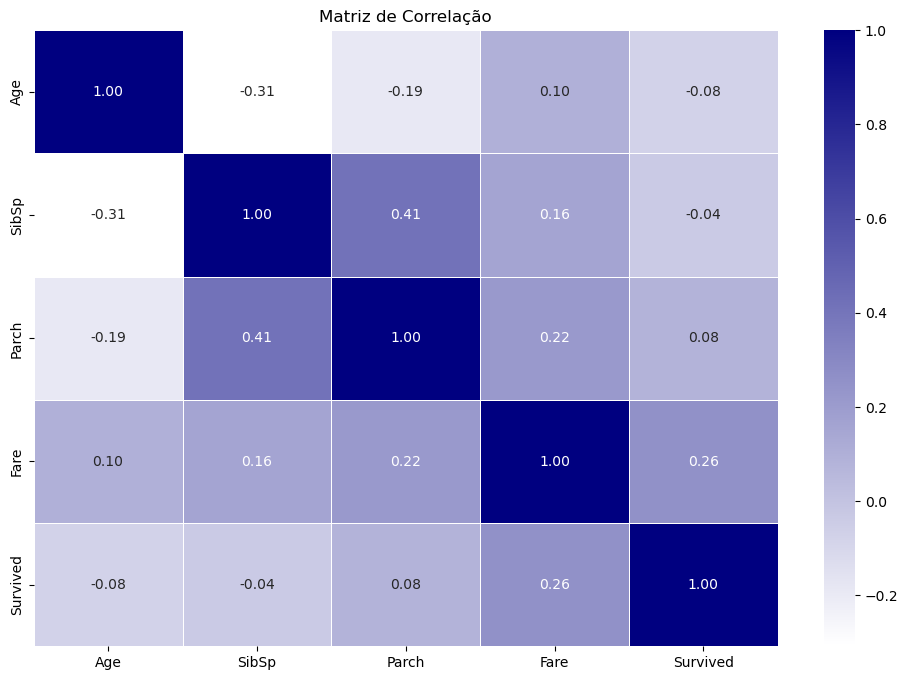

In [12]:
correlation_matrix = df_train[['Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr()

base_color = (0.0, 0.0, 0.5)  
cmap = LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), base_color], N=256)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

### 2.3 Taxa de Sobreviênvia (Target)

In [13]:
# salvando o resultado em um dataframe
df_target = pd.DataFrame(df_train.Survived.value_counts())

# calculando a proporcao
df_target['Proporção'] = (df_target['Survived'] / df_target['Survived'].sum()) * 100

df_target

,Survived,Proporção
0,549,61.62
1,342,38.38


Temos um conjunto de dados desbalanceado, com apenas 38% das instâncias do conjunto de treinamento representando sobreviventes. Portanto, é necessário realizar um balanceamento ou ajustar os pesos das classes durante a modelagem.

### 2.4 Análise Bivariada das Variáveis (Target)

#### 2.4.1 Pclass vs Survived

A classe com o maior número de passageiros foi a terceira classe. No entanto, essa classe teve a menor taxa de sobrevivência. A taxa de sobrevivência foi mais alta entre os passageiros da primeira classe, seguida pela segunda e terceira classes.

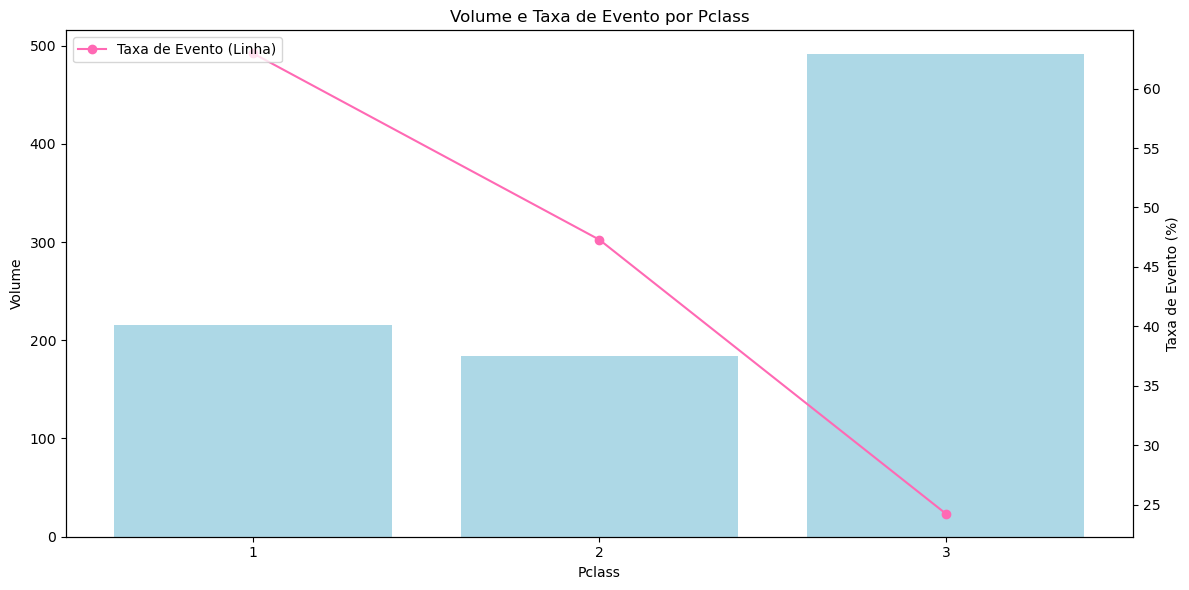

,Pclass,Taxa_de_Evento,Volume
0,1,62.96,216
1,2,47.28,184
2,3,24.24,491


In [14]:
analyze_variable(df_train, 'Pclass', 'Survived')

#### 2.4.2 Sex vs Survived

Nos dados de treino, aproximadamente 64% dos passageiros são do sexo masculino; no entanto, eles têm uma taxa de sobrevivência menor do que os passageiros do sexo feminino.

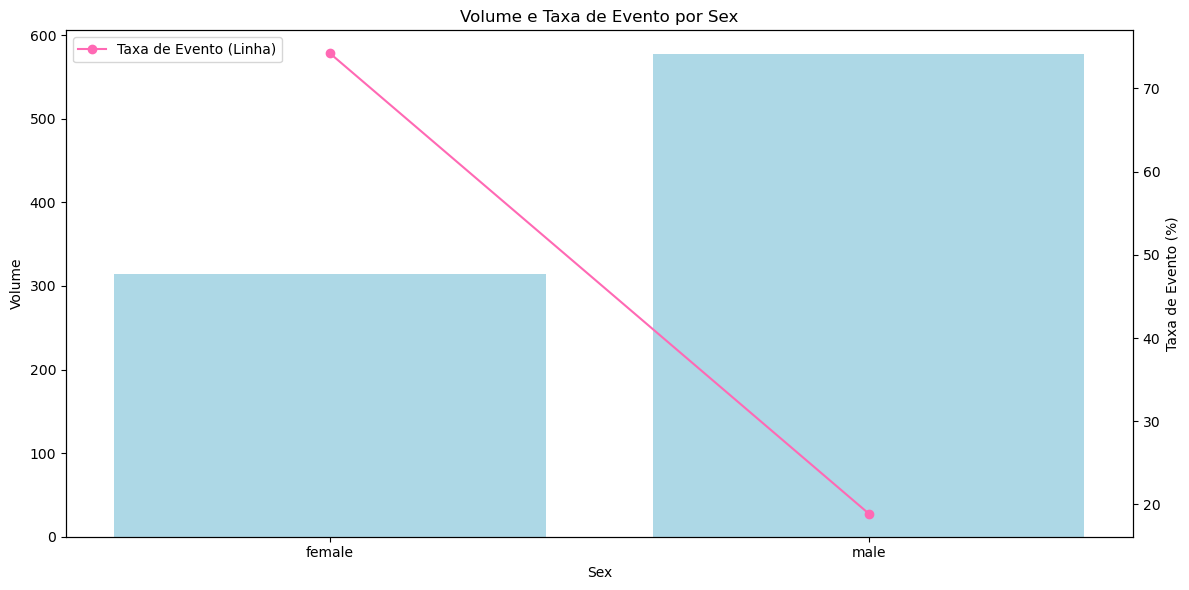

,Sex,Taxa_de_Evento,Volume
0,female,74.20,314
1,male,18.89,577


In [15]:
analyze_variable(df_train, 'Sex', 'Survived')

#### 2.4.3 Age vs Survived

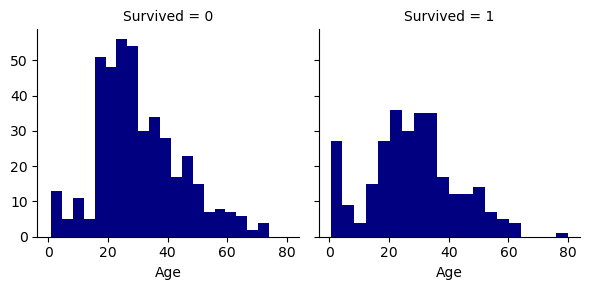

In [16]:
g = sns.FacetGrid(df_train, col = 'Survived')
g.map(plt.hist, 'Age', bins = 20, color = (0.0, 0.0, 0.5));

Analisando a distribuição da característica *Age* em relação ao target, observamos que:

1. A maioria dos sobreviventes tinha entre 18 e 38 anos;

2. Houve sobreviventes com menos de um ano de idade;

3. Também tivemos sobreviventes com 80 anos de idade.

#### 2.4.5 Embarked vs Survived

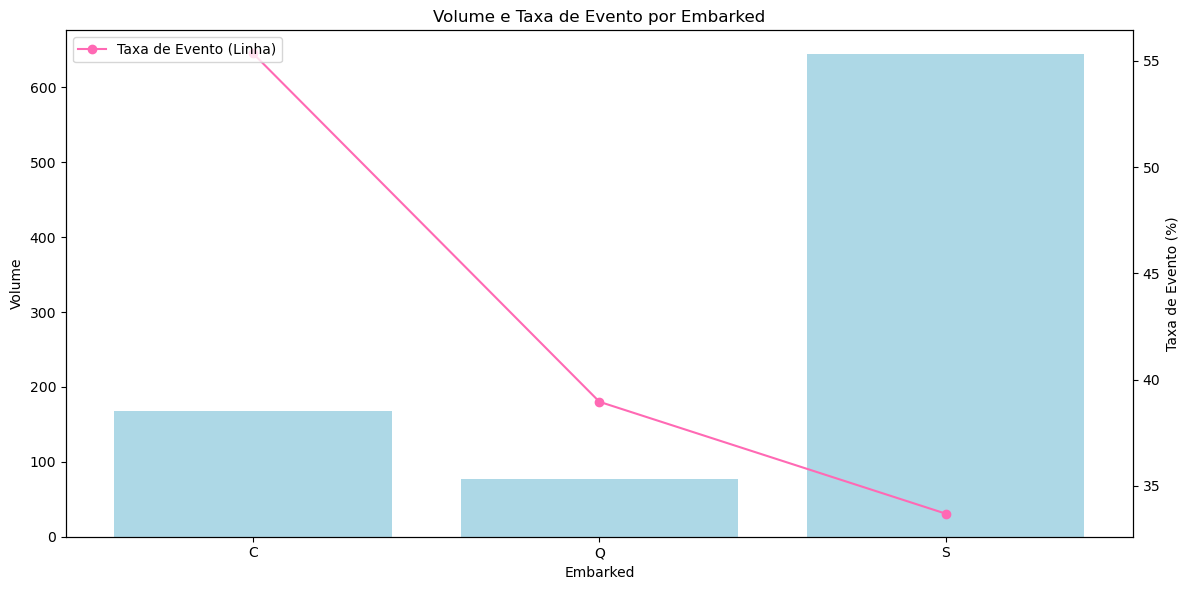

,Embarked,Taxa_de_Evento,Volume
0,C,55.36,168
1,Q,38.96,77
2,S,33.70,644


In [17]:
analyze_variable(df_train, 'Embarked', 'Survived')

A maior parte dos passageiros embarcou no porto de Southampton, seguido por Cherbourg e Queenstown. Em termos de taxa de sobrevivência, os passageiros que embarcaram em Cherbourg apresentaram a menor taxa de mortalidade, seguidos por Queenstown e Southampton.

#### 2.4.6 Fare vs Survived

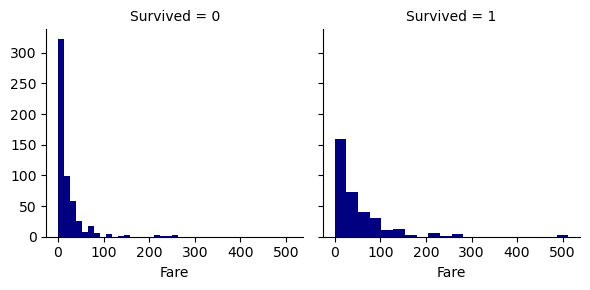

In [18]:
g = sns.FacetGrid(df_train, col = 'Survived')
g.map(plt.hist, 'Fare', bins = 20, color = (0.0, 0.0, 0.5));

Analisando o valor dos tickets dos passageiros sobreviventes e não sobreviventes, fica evidente que os passageiros das classes superiores (1 e 2), que tinham tickets mais caros, tiveram uma maior taxa de sobrevivência.

### 2.5 Análise Multivariada das Variáveis (Target)

#### 2.5.1 Age, Pclass e Survived

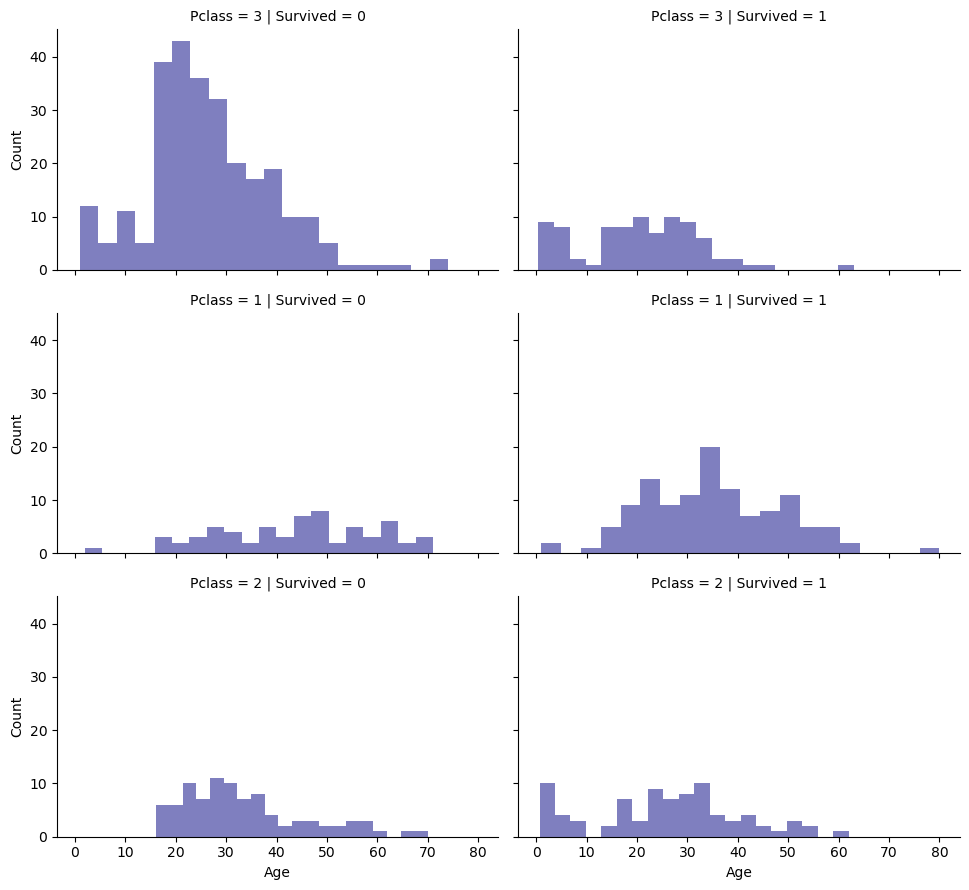

In [19]:
grid = sns.FacetGrid(df_train, col = 'Survived', row = 'Pclass', aspect = 1.6)

grid.map(plt.hist, 'Age', alpha = 0.5, bins=20, color = (0.0, 0.0, 0.5))

grid.set_axis_labels('Age', 'Count')
plt.show()

De acordo com o gráfico acima, com exceção dos passageiros da terceira classe, observou-se uma maior taxa de sobrevivência entre os passageiros mais idosos nas segunda e primeira classes.

#### 2.5.2 Age, Sex e Survived

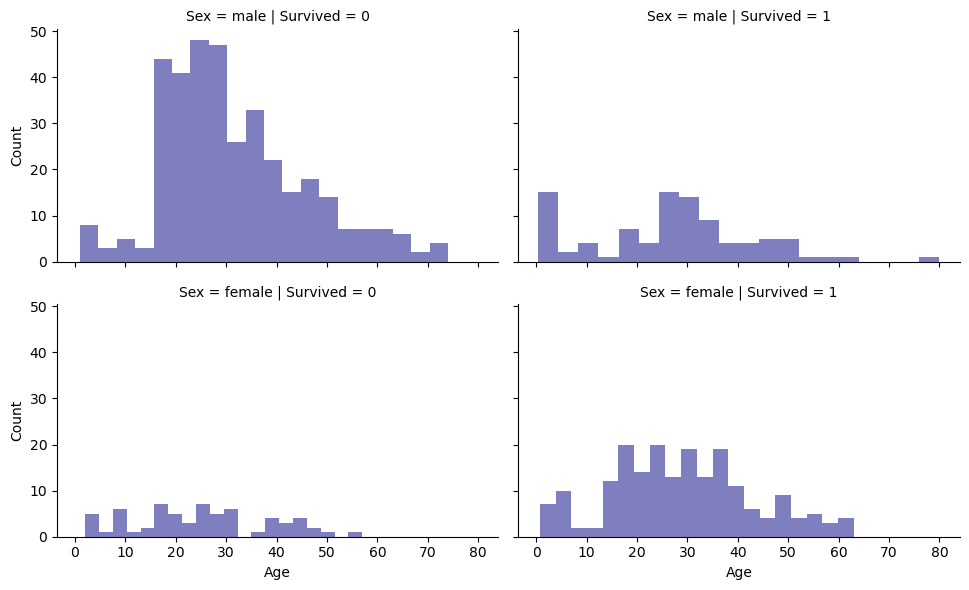

In [20]:
grid = sns.FacetGrid(df_train, col = 'Survived', row = 'Sex', aspect = 1.6)

grid.map(plt.hist, 'Age', alpha = 0.5, bins=20, color = (0.0, 0.0, 0.5))

grid.set_axis_labels('Age', 'Count')
plt.show()

Observou-se uma maior taxa de sobrevivência entre jovens do sexo feminino em comparação com os jovens do sexo masculino. Para os homens, a taxa de mortalidade foi mais alta entre os jovens.

## 3. Pré-Processamento

### 3.1 Separação em Variáveis Explicativas e Target

In [21]:
# variaveis explicativas
df_x = df_train.drop(columns = ['Survived'])

# target
df_y = df_train[['Survived']]

### 3.2 Pré-Processamento

#### 3.2.1 Pipeline

In [22]:
# classe para drop das caracteristicas que nao serao utilizados

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As colunas seguintes estão ausentes no DataFrame: {missing_cols}")
            
        return X.drop(columns=self.columns)

columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

cat_cols = ['Sex', 'Embarked', 'Pclass']

num_cols = ['Age', 'SibSp', 'Parch', 'Fare']

############### Variaveis Categoricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(drop = 'first', sparse = False))
])

############### Variaveis Numericas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

# columnTransformer com as transformações
preprocessor = ColumnTransformer(
    transformers = [
        ('drop_col', DropColumns(columns = columns_to_drop), columns_to_drop),
        ('cat', cat_pipeline, cat_cols),  
        ('num', num_pipeline, num_cols) 
    ],
    remainder = 'drop'  
)

#### 3.2.2 Processamento da base de Treino

In [23]:
# fit e transform da pipeline de pré-processmento
df_x_transformed = preprocessor.fit_transform(df_x)

# obtendo os nomes das colunas
feature_names = get_transformed_feature_names(preprocessor, cat_cols, num_cols)

df_x_transformed = pd.DataFrame(df_x_transformed, columns = feature_names)

In [24]:
# visualizando as cinco primeiras entradas do df transformado
df_x_transformed.head()

,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Age,SibSp,Parch,Fare
0,1.00,0.00,1.00,0.00,1.00,-0.59,0.43,-0.47,-0.50
1,0.00,0.00,0.00,0.00,0.00,0.64,0.43,-0.47,0.79
2,0.00,0.00,1.00,0.00,1.00,-0.28,-0.47,-0.47,-0.49
3,0.00,0.00,1.00,0.00,0.00,0.41,0.43,-0.47,0.42
4,1.00,0.00,1.00,0.00,1.00,0.41,-0.47,-0.47,-0.49


#### 3.2.3 Processamento da base de Test

In [25]:
# fit e transform da pipeline de pré-processmento
df_test_x_transformed = preprocessor.fit_transform(df_test_x)

# obtendo os nomes das colunas
feature_names = get_transformed_feature_names(preprocessor, cat_cols, num_cols)

df_test_x_transformed = pd.DataFrame(df_test_x_transformed, columns = feature_names)

In [26]:
# visualizando as cinco primeiras entradas do df transformado
df_test_x_transformed.head()

,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Age,SibSp,Parch,Fare
0,1.00,1.00,0.00,0.00,1.00,0.33,-0.50,-0.40,-0.50
1,0.00,0.00,1.00,0.00,1.00,1.33,0.62,-0.40,-0.51
2,1.00,1.00,0.00,1.00,0.00,2.51,-0.50,-0.40,-0.47
3,1.00,0.00,1.00,0.00,1.00,-0.26,-0.50,-0.40,-0.48
4,0.00,0.00,1.00,0.00,1.00,-0.66,0.62,0.62,-0.42


## 4. Modelagem

### 4.1 Baseline (Random Forest)

In [27]:
# intanciando o modelo
rf_model = RandomForestClassifier(random_state = 42)

# validação cruzada
cv_scores = cross_val_score(rf_model, df_x_transformed, df_y, cv = 3, scoring = 'accuracy')

cv_scores_rounded = [round(score, 2) for score in cv_scores]
mean_score = round(cv_scores.mean(), 2)
std_score = round(cv_scores.std(), 2)

print(f'Acurácia de cada fold: {cv_scores_rounded}')
print(f'Média da Acurácia: {mean_score}')
print(f'Desvio padrão da Acurácia: {std_score}')

Acurácia de cada fold: [0.79, 0.82, 0.78]
Média da Acurácia: 0.8
Desvio padrão da Acurácia: 0.02


### 4.1 Random Forest

#### 4.1.1 Tuning de Parâmetros

In [41]:
# instanciando o modelo
model = RandomForestClassifier(random_state=42)

# grid de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 150, 200]        
    , 'max_depth': [6, 8, 10, 20, 30]         
    , 'min_samples_split': [2, 5, 10]         
    , 'min_samples_leaf': [1, 2, 4]          
    , 'max_features': ['auto', 'sqrt', 'log2'] 
    , 'class_weight': ['balanced']
}

# Config do GridSearchCV
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                           scoring = 'accuracy', cv = 3, verbose = 10, n_jobs = -1)

# fit
grid_search.fit(df_x_transformed, df_y)

# melhores parâmetros e o melhor score
print(f'Melhores parâmetros: {grid_search.best_params_}')
print(f'Melhor score de validação: {grid_search.best_score_}')

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Melhor score de validação: 0.8249158249158249


#### 4.1.2 Validação Cruzada e Fit

In [34]:
# intanciando o modelo
rf_model = RandomForestClassifier( n_estimators = 200
                                   , max_depth = 8
                                   , min_samples_split = 2
                                   , min_samples_leaf = 1
                                   , max_features = 'auto'
                                   , class_weight = 'balanced'
                                   , random_state = 42
                                 )

# validação cruzada
cv_scores = cross_val_score(rf_model, df_x_transformed, df_y, cv = 3, scoring = 'accuracy')

cv_scores_rounded = [round(score, 2) for score in cv_scores]
mean_score = round(cv_scores.mean(), 2)
std_score = round(cv_scores.std(), 2)

print(f'Acurácia de cada fold: {cv_scores_rounded}')
print(f'Média da Acurácia: {mean_score}')
print(f'Desvio padrão da Acurácia: {std_score}')

# fit do modelo
rf_model.fit(df_x_transformed, df_y)

df_train_y_predict = rf_model.predict(df_x_transformed)

df_test_y_predict = rf_model.predict(df_test_x_transformed)

Acurácia de cada fold: [0.81, 0.84, 0.82]
Média da Acurácia: 0.82
Desvio padrão da Acurácia: 0.01


#### 4.1.3 Avaliação do Modelo

Como não temos o target para os dados de teste, iremos avaliar o modelo utilizando os dados de treino.

##### Matriz de Confusão

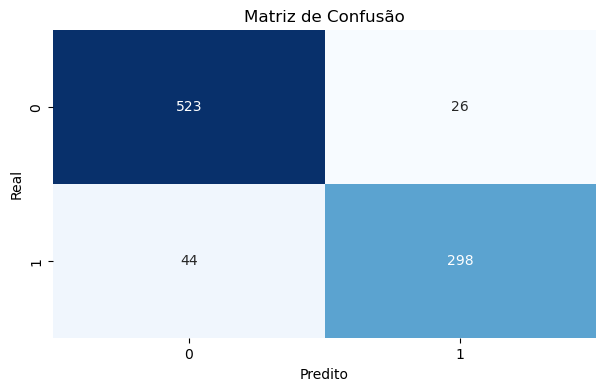

In [35]:
# matriz de confusão
cm = confusion_matrix(df_y, df_train_y_predict)

# plot da matriz de confusão
plt.figure(figsize = (7, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

##### Report

In [36]:
print(classification_report(df_y, df_train_y_predict))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       549
           1       0.92      0.87      0.89       342

    accuracy                           0.92       891
   macro avg       0.92      0.91      0.92       891
weighted avg       0.92      0.92      0.92       891



Essas métricas sugerem que o modelo está funcionando razoavelmente bem, com uma alta taxa de classificações corretas e um bom equilíbrio entre precisão e revocação. A matriz de confusão revela que, quando o modelo prevê que um passageiro é sobrevivente (classe positiva), ele está correto 92% das vezes. Isso significa que de todas as instâncias classificadas como sobreviventes, 92% realmente são sobreviventes. Além disso, o modelo detecta corretamente 87% dos casos de sobreviventes reais. Isso indica que o modelo é capaz de identificar 85% dos verdadeiros sobreviventes no conjunto de dados.

##### Curva ROC

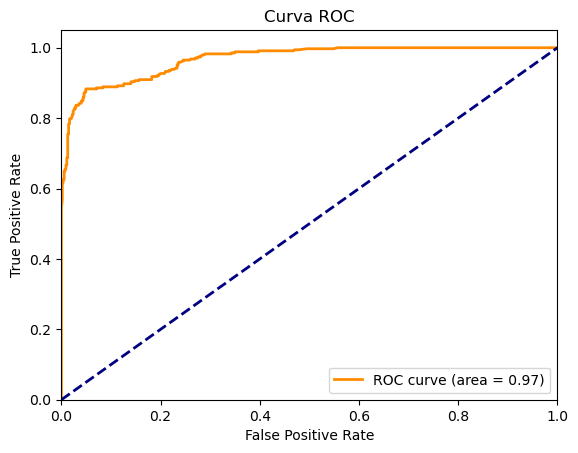

In [55]:
df_train_y_scores = rf_model.predict_proba(df_x_transformed)[:, 1]

fpr, tpr, _ = roc_curve(df_y, df_train_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Uma área sob a curva ROC (AUC-ROC) de 0.91 confirma que o modelo tem uma excelente capacidade de distinguir entre as classes positivas e negativas

##### Feature Importance

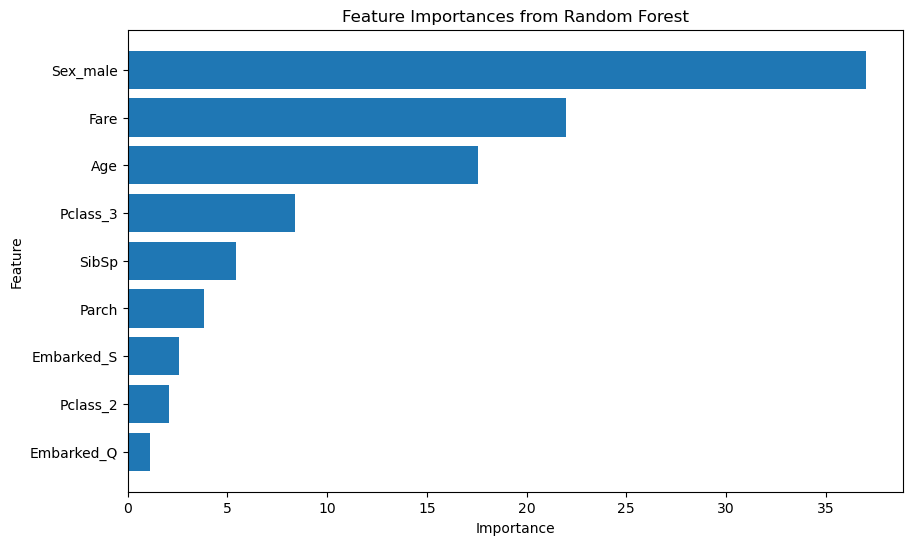

In [53]:
feature_importances = rf_model.feature_importances_

feature_names = df_x_transformed.columns

# dataframe com a importancia das variaveis
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df['Importance'] = importance_df['Importance'] * 100

# ordenando o dataframe de acordo com a importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plot as importâncias das variáveis
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].iloc[:30], importance_df['Importance'].iloc[:30])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importância das Variáveis')
plt.gca().invert_yaxis()  
plt.show()

Analisando a importância das variáveis, observamos que a flag para o sexo masculino é a variável mais significativa. Isso faz sentido, considerando que apenas 18% dos sobreviventes eram do sexo masculino, o que sugere que o sexo masculino foi um fator crítico para a sobrevivência.

A segunda variável mais importante é o valor do ticket. Como vimos na análise exploratória, um ticket com um valor mais alto estava associado a uma maior taxa de sobrevivência. Isso indica que a classe econômica pode ter desempenhado um papel importante na probabilidade de sobrevivência.

A terceira variável é a idade. Nossa análise exploratória mostrou que a taxa de sobrevivência foi mais alta entre os jovens, especialmente aqueles com idades entre 18 e 38 anos. Isso sugere que a idade também foi um fator relevante para a sobrevivência.

### 4.2 XGBoost

#### 4.2.1 Tuning de Parâmetros

In [67]:
from xgboost import XGBClassifier

# instanciando o modelo
xgb_model = XGBClassifier(random_state = 42, use_label_encoder = False, eval_metric = 'auc')

# grid de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [6, 8, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Config do GridSearchCV
grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                           scoring = 'roc_auc', cv = 3, verbose = 10, n_jobs = -1)

# fit
grid_search.fit(df_x_transformed, df_y)

# melhores parâmetros e o melhor score
print(f'Melhores parâmetros: {grid_search.best_params_}')
print(f'Melhor score de validação: {grid_search.best_score_}')

Fitting 3 folds for each of 34560 candidates, totalling 103680 fits
Melhores parâmetros: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.6}
Melhor score de validação: 0.8705541175342729


#### 4.2.2 Validação Cruzada e Fit

In [43]:
# intanciando o modelo
xgb_model = XGBClassifier(
    n_estimators = 50
    , max_depth = 6
    , learning_rate = 0.2
    , subsample = 0.6
    , colsample_bytree = 0.6 
    , gamma = 0.1
    , reg_alpha = 1
    , reg_lambda = 0.1
    , random_state = 42
    , use_label_encoder = False
    , eval_metric = 'auc')

# validação cruzada
cv_scores = cross_val_score(xgb_model, df_x_transformed, df_y, cv = 3, scoring = 'roc_auc')

cv_scores_rounded = [round(score, 2) for score in cv_scores]
mean_score = round(cv_scores.mean(), 2)
std_score = round(cv_scores.std(), 2)

print(f'Acurácia de cada fold: {cv_scores_rounded}')
print(f'Média da Acurácia: {mean_score}')
print(f'Desvio padrão da Acurácia: {std_score}')

# fit do modelo
xgb_model.fit(df_x_transformed, df_y)

df_train_y_predict = xgb_model.predict(df_x_transformed)

df_test_y_predict = xgb_model.predict(df_test_x_transformed)

Acurácia de cada fold: [0.84, 0.88, 0.89]
Média da Acurácia: 0.87
Desvio padrão da Acurácia: 0.02


#### 4.2.3 Avaliação do Modelo

Como não temos o target para os dados de teste, iremos avaliar o modelo utilizando os dados de treino.

##### Matriz de Confusão

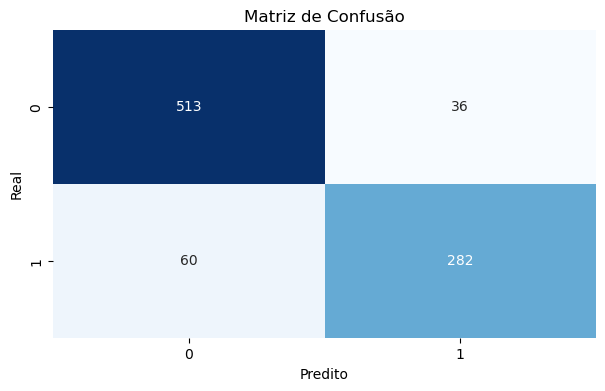

In [44]:
# matriz de confusão
cm = confusion_matrix(df_y, df_train_y_predict)

# plot da matriz de confusão
plt.figure(figsize = (7, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

##### Report

In [45]:
print(classification_report(df_y, df_train_y_predict))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       549
           1       0.89      0.82      0.85       342

    accuracy                           0.89       891
   macro avg       0.89      0.88      0.88       891
weighted avg       0.89      0.89      0.89       891



##### Curva ROC

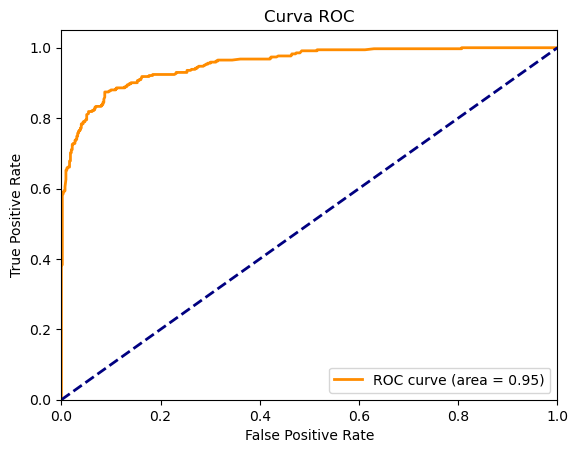

In [54]:
df_train_y_scores = xgb_model.predict_proba(df_x_transformed)[:, 1]

fpr, tpr, _ = roc_curve(df_y, df_train_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### 4.3 Análise comparativa entre os modelos

* Acurácia: 
    O modelo Random Forest tem uma acurácia de 0.92, enquanto o XGBoost tem 0.89. Portanto, o Random Forest é melhor em termos de acurácia.
    
 * F1-Score:
    Para as duas classes, o Random Forest é melhor que o XGBoost.
    
* Precisão: 
    Ambas as classes no Random Forest têm precisão de 0.92, enquanto no XGBoost, a precisão é ligeiramente menor.
    
* Recall: O Random Forest tem um recall melhor para a classe 1 (0.87 vs 0.82), mas XGBoost tem um recall ligeiramente melhor para a classe 0 (0.93 vs 0.95).

Além disso, o Random Forest tem um AUC superior ao AUC do XGBoost.

Com base nas métricas fornecidas, o modelo Random Forest apresenta um desempenho geral melhor em termos de acurácia, precisão e F1-score para ambas as classes e considerando o AUC também. Portanto, o Random Forest pode ser considerado o melhor modelo entre os dois para este conjunto de dados.